# Implementation of Variational AutoEncoder (VAE)

     VAE from "Auto-Encoding Variational Bayes" (2014, D.P. Kingma et. al.)
    
     Kernel-author: Jackson Kang @ Deep-learning Lab. (Handong Global University, S.Korea)
     
     Author-email:  mskang@handong.edu

     python and pytorch version: python=3.7, pytorch=1.3.1

In [3]:
import torch
import torch.nn as nn

import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image

In [4]:
print(torch.__version__)
print(torch.cuda.is_available())

1.8.1
True


In [5]:
# Model Hyperparameters

dataset_path = './datasets'

cuda = True
DEVICE = torch.device("cuda" if cuda else "cpu")


batch_size = 100

x_dim  = 784
hidden_dim = 400
latent_dim = 20

lr = 1e-3

epochs = 20

###    Step 1. Load (or download) Dataset

In [6]:
#!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
#!tar -zxvf MNIST.tar.gz


from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


#train_data = MNIST(root = './', train=True, download=True, transform=transform)
#val_data = MNIST(root = './', train=False, download=True, transform=transform)

mnist_transform = transforms.Compose([
        transforms.ToTensor(),
])

kwargs = {'num_workers': 1, 'pin_memory': True} 

train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=True,  **kwargs)

### Step 2. Define our model: Variational AutoEncoder (VAE)

In [7]:
"""
    A simple implementation of Gaussian MLP Encoder and Decoder
"""

class Encoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        
        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_mean  = nn.Linear(hidden_dim, latent_dim)
        self.FC_var   = nn.Linear (hidden_dim, latent_dim)
        self.training = True
        
    def forward(self, x):
        h_       = torch.relu(self.FC_input(x))
        mean     = self.FC_mean(h_)
        log_var  = self.FC_var(h_)                     # encoder produces mean and log of variance 
                                                       #             (i.e., parateters of simple tractable normal distribution "q")
        var      = torch.exp(0.5*log_var)              # takes exponential function
        z        = self.reparameterization(mean, var)
        
        return z, mean, log_var
    
    
    def reparameterization(self, mean, var,):
        epsilon = torch.rand_like(var).to(DEVICE)        # sampling epsilon
        
        z = mean + var*epsilon                          # reparameterization trick
        
        return z

In [8]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        h     = torch.relu(self.FC_hidden(x))
        x_hat = torch.sigmoid(self.FC_output(h))
        return x_hat
        

In [9]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
                
    def forward(self, x):
        z, mean, log_var = self.Encoder(x)
        x_hat            = self.Decoder(z)
        
        return x_hat, mean, log_var

In [10]:
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(DEVICE)

### Step 3. Define Loss function (reprod. loss) and optimizer

In [11]:
from torch.optim import Adam

BCE_loss = nn.BCELoss()

def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD


optimizer = Adam(model.parameters(), lr=lr)

### Step 4. Train Variational AutoEncoder (VAE)

In [12]:
print("Start training VAE...")
model.train()

for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var)
        
        overall_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))
    
print("Finish!!")

Start training VAE...
	Epoch 1 complete! 	Average Loss:  135.98979484035894
	Epoch 2 complete! 	Average Loss:  99.40813005399625
	Epoch 3 complete! 	Average Loss:  94.66298515103297
	Epoch 4 complete! 	Average Loss:  92.07780470706386
	Epoch 5 complete! 	Average Loss:  90.40919809382825
	Epoch 6 complete! 	Average Loss:  89.22091299626983
	Epoch 7 complete! 	Average Loss:  88.38747739559422
	Epoch 8 complete! 	Average Loss:  87.71280888883817
	Epoch 9 complete! 	Average Loss:  87.18203561110967
	Epoch 10 complete! 	Average Loss:  86.76224782189065
	Epoch 11 complete! 	Average Loss:  86.4600194171275
	Epoch 12 complete! 	Average Loss:  86.13435937336968
	Epoch 13 complete! 	Average Loss:  85.91067958315944
	Epoch 14 complete! 	Average Loss:  85.69160435850115
	Epoch 15 complete! 	Average Loss:  85.45404076781615
	Epoch 16 complete! 	Average Loss:  85.2498807745983
	Epoch 17 complete! 	Average Loss:  85.13230155728297
	Epoch 18 complete! 	Average Loss:  84.99388398796171
	Epoch 19 comple

### Step 5. Evaluate the model

In [17]:
import matplotlib.pyplot as plt

In [18]:
model.eval()

with torch.no_grad():
    for batch_idx, (x, _) in enumerate(tqdm(test_loader)):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)
        
        x_hat, _, _ = model(x)
        
        break

  0%|          | 0/100 [00:01<?, ?it/s]


In [19]:
def show_image(x, idx):
    x = x.view(batch_size, 28, 28)

    fig = plt.figure()
    plt.imshow(x[idx].cpu().numpy())

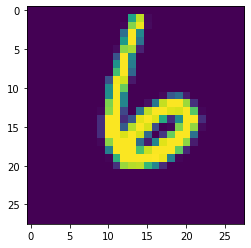

In [20]:
show_image(x, idx=0)

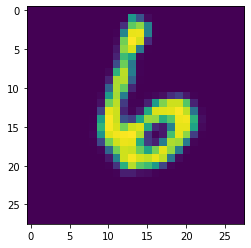

In [21]:
show_image(x_hat, idx=0)

### Step 6. Generate image from noise vector

In [22]:
with torch.no_grad():
    noise = torch.randn(batch_size, latent_dim).to(DEVICE)
    generated_images = decoder(noise)

In [23]:
save_image(generated_images.view(batch_size, 1, 28, 28), 'generated_sample.png')

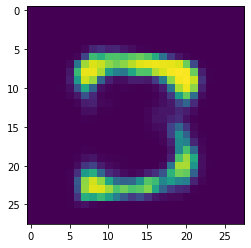

In [27]:
show_image(generated_images, idx=1)

In [29]:
train_dataset.classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [31]:
train_loader.dataset.classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']